In [1]:
#!pip install pyarrow

In [1]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
import math
import locale
from common import MUNI_SECURITY_TYPE_DICT, COUPON_TYPE_DICT, COUPON_FREQUENCY_DICT, transform_to_datetime, diff_in_days, actual_diff_in_days, get_next_coupon_date, get_previous_coupon_date, get_time_delta_from_interest_frequency, get_ytw_and_price_data, transform_ytw_and_price_data
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
from time import sleep
from datetime import datetime,timedelta,date,time
from tqdm import tqdm, tqdm_notebook
from pandas import NaT
sns.set();

locale.setlocale( locale.LC_ALL, 'en_US' )

tqdm_notebook().pandas()

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

<ipython-input-1-eb8253d69ad5>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

#### Todo: If MSRB and ICE provide the same field, such as coupon rate, then we should query both and raise a warning if they disagree. This type of checking can be kept clearly separate from the actual calculation code. For some MSRB fields like msrb.dated_date, we want to know how they map to ICE fields such as issue_date.

### we only support Fixed rate, Original issue discount and Zero coupon, for now. Need to expand this:

In [12]:
bqclient = bigquery.Client()
muni_df = get_ytw_and_price_data(bqclient, '2021-01-13')
transform_ytw_and_price_data(muni_df)

#print(muni_df["coupon_type"].value_counts().plot(kind = 'barh'))

len(muni_df)

19538

In [13]:
print(len(muni_df[muni_df['is_called'] == True]))
print(len(muni_df[(muni_df['is_called'] == False) & (muni_df['is_callable'] == False)]))
print(len(muni_df[(muni_df['called_redemption_type'].notnull()) & 
                  (muni_df['called_redemption_type'] != 18) &
                 (muni_df['called_redemption_type'] != 19)]))

1977
0
1977


### Use 360/30 convention for days: 

##### We doubt that get_time_delta_from_interest_frequency works with every value in the coupon_frequency dictionary. Need to add some checks for correctness, and some detailed comments.

frequency_dict_text = {0:'Unknown',	1:'Semiannually',	2:'Monthly',	3:'Annually',	4:'Weekly',	5:'Quarterly',	6:'Every 2 years',	7:'Every 3 years',	8:'Every 4 years',	9:'Every 5 years',	10:'Every 7 years',	11:'Every 8 years',	12:'Biweekly',	13:'Changeable',	14:'Daily',	15:'Term mode',	16:'Interest at maturity',	17:'Bimonthly',	18:'Every 13 weeks',	19:'Irregular',	20:'Every 28 days',	21:'Every 35 days',	22:'Every 26 weeks',	23:'Not Applicable',	24:'Tied to prime',	25:'One time',	26:'Every 10 years',	27:'Frequency to be determined',	28:'Mandatory put',	29:'Every 52 weeks',	30:'When interest adjusts-commercial paper',	31:'Zero coupon',	32:'Certain years only',	33:'Under certain circumstances',	34:'Every 15 years',	35:'Custom',	36:'Single Interest Payment'}

### get_yield function paramenters should be pruned to the ones needed

In [14]:
def get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date):
    
   #Y is the yield
    guess = 0.01
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);        
    P = dollar_price # the dollar price of the security for each $100 par value;
    R = coupon_rate # the annual interest rate expressed as a percentage, i.e., dollars per $100;
    RV = par # the redemption value of the security per $100 par value; and
    M = interest_payment_frequency 
    number_of_interest_payments = 0

    if R != 0 and interest_payment_frequency !=0: # Coupon paid every M periods
        last_date = next_coupon_date

        # count the coupon payment periods left: 
        while last_date <= end_date: # end_date: maturity_date or next_call_date
            number_of_interest_payments += 1
            last_date += time_delta

        final_coupon_date = last_date - time_delta

        if pd.isnull(prev_coupon_date): prev_coupon_date = dated_date

        N = number_of_interest_payments    
        D = diff_in_days(end_date,final_coupon_date,"360/30") #Time from final Payment to Redemption, can be Zero  
        A = diff_in_days(settlement_date,prev_coupon_date,"360/30") # accrued days from beginning of the interest payment period
        E = B/M # number of days in interest payment period 

        # formula to handle one coupon left paid at maturity (or call date)
        if end_date<=next_coupon_date:
            DTC = diff_in_days(end_date,prev_coupon_date) # accrual days for final paid coupon
            DA = diff_in_days(settlement_date,prev_coupon_date) # accrual days for coupon owed in dirty price
            DM = diff_in_days(end_date,settlement_date) # hold period days
            
            # formula is ((Redemption Value + Coupon Paid at Maturity)/Dirty Price - 1) * 
            # (100 *  Payments per Year)/(Hold Period scaled for payments per year)
            return round( (((RV+(R/M)*(DTC*M/B))/(P+(R/M)*(DA*M/B)))-1)*(M*100)/(DM*M/B),3)

        else:
            #print('P=%s\nRV=%s\nR=%s\nD=%s\nB=%s\nY=%s\nM=%s\nN=%s\nE=%s\nA=%s\nrange(N)==%s\n' %(P,RV,R,D,B,'_',M,N,E,A,range(N)))    
            ytm_func = lambda Y: (RV + R*D/B)/(1+Y/M)**(N-1 + (E-A)/E + D/E) + sum([(R/M)/(1+Y/M)**(K+(E-A)/E) for K in range(N)]) - (P + R*A/B)        
                
    elif R != 0 and interest_payment_frequency == 0:
        # Interest at maturity, Rule 33-G (b)(i)A(b) - why do we get them as negatives??
        A = diff_in_days(settlement_date,dated_date,"360/30")
        DIR = diff_in_days(end_date,dated_date,"360/30")
        ytm_func = lambda Y: ((RV + (DIR/B*R))/(1-((DIR-A)/B*Y)))-(P + R*A/B)
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)*-1 #fix this * -1. (check by pluggin in the positive)
    
    elif R == 0:
        # for Zero coupon use semi annual 360/30 convention
        periods = diff_in_days(end_date,settlement_date)/180.0
        ytm = ((par/P)**(1/periods)-1)*200
        return round(ytm,3)
    try:
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)
    except Exception as e:
        print(e)
        return None

In [15]:
def compute_yield(x):

    time_delta = get_time_delta_from_interest_frequency(x.interest_payment_frequency)
    my_prev_coupon_date,my_next_coupon_date = None, None
    # Explain: why is data missing? Why do we need to change an exisiting next_coupon_payment_date?   
    if x.coupon_rate != 0 and x.interest_payment_frequency != 0:
        my_next_coupon_date = pd.to_datetime(x.next_coupon_payment_date)
        my_prev_coupon_date = pd.to_datetime(x.previous_coupon_payment_date)

        if (pd.isnull(x.previous_coupon_payment_date)):
            my_prev_coupon_date = get_previous_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
        if  (pd.isnull(x.next_coupon_payment_date)):
            my_next_coupon_date = get_next_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
        if x.next_coupon_payment_date < x.settlement_date and pd.isnull(x.previous_coupon_payment_date):
            my_next_coupon_date = get_next_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
    
    if (not x.is_called) and (not x.is_callable):
        end_date = x.maturity_date
        par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,my_next_coupon_date,
                        end_date,x.settlement_date,x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        return ytm
    
    if x.is_called:
        if x.called_redemption_type == 1 or x.called_redemption_type == 5:
            end_date = x.maturity_date
        else:
            end_date = x.refund_date              
        if not pd.isnull(x.refund_price):
            par = x.refund_price
        elif not pd.isnull(x.next_call_price): 
            par = x.next_call_price
        else: 
            par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        return ytm
    
    else:
        
        ytf = float("inf")
        ytm = float("inf")
        yta = float("inf")
        ytp = float("inf")        
        
        if not pd.isnull(x.par_call_date):
            end_date = x.par_call_date
            par = x.par_call_price    
            ytp = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                            my_next_coupon_date,end_date,x.settlement_date,
                            x.dated_date,x.interest_payment_frequency,
                            x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)

        end_date = x.next_call_date #+ relativedelta(days=1)
        par = x.next_call_price    
        ytf = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        
        end_date = x.maturity_date
        par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        
        # yield to anytime call below does not change anything, and we should rmeove this code after some testing: 
        yields = (ytf, ytm, yta,ytp)
    

        return(min(yields))


In [16]:
muni_df['computed_ytw'] = muni_df.progress_apply(lambda x: compute_yield(x),axis=1)

  0%|          | 0/19538 [00:00<?, ?it/s]

### the below cells evaluate the results and top discrepancies:

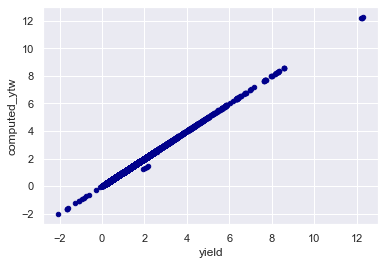

In [17]:
ax = muni_df.plot.scatter(x='yield',y='computed_ytw', c='DarkBlue')

In [18]:
muni_df['ytw_delta'] = muni_df['computed_ytw'] - muni_df['yield']

In [19]:
delta = muni_df.sort_values(by=['ytw_delta'])#,ascending=False)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30
delta = delta[delta.ytw_delta != 0]

In [20]:
#how many did we get right: 
print(len(muni_df[muni_df['computed_ytw'] == muni_df['yield']])/len(muni_df))
print(len(muni_df[abs(muni_df['computed_ytw'] - muni_df['yield']) <= 0.001])/len(muni_df))

0.9835704780427884
0.9910942778175862
